In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import os

In [3]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/"
else:
  file_dir = "H:/github/python/seafog/"

In [5]:
file_59754 = os.path.normpath(os.path.join(file_dir, './data/station/59754.20130101-2022093023.csv'))
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59754.index = pd.to_datetime(df_59754["DDATETIME"])

df_code = pd.read_csv(os.path.normpath(os.path.join(file_dir, './code_readme.csv')),sep=',')

C:\Users\Henry\AppData\Local\Temp\ipykernel_1128\2792315665.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])


In [11]:
print(df_59754.columns)

Index(['DDATETIME', 'V01301', 'D_RYMDHM', 'D_IYMDHM', 'V04001', 'V04002',
       'V04003', 'V04004', 'V04005', 'V05001',
       ...
       'V13925', 'V13930', 'V13935', 'V13940', 'V13945', 'V13950', 'V13955',
       'V13960', 'FLAG_ELEMENTS', 'FLAG_RAIN'],
      dtype='object', length=129)


In [19]:
code_info = {
  'vis01':'V20059',
  'vis':'V20001',
  'td': 'V12003',
  't2m': 'V12001',
  "year":"V04001",
  "month": "V04002",
  "date": "V04003",
  "hour":"V04004",
  "minute":"V04005",
  "rhum":"V13003",
  'rain01':'V13019',
}

In [20]:
# 筛选雾出现的行

df_fog = df_59754.loc[df_59754[code_info['vis']]<=1000]
print(df_fog)


                                 DDATETIME  V01301               D_RYMDHM  \
DDATETIME                                                                   
2013-02-03 18:00:00  2013-02-03 18:00:00.0   59754  2013-02-03 18:05:45.0   
2013-02-03 21:00:00  2013-02-03 21:00:00.0   59754  2013-02-03 21:05:55.0   
2013-02-27 00:00:00  2013-02-27 00:00:00.0   59754  2013-02-27 00:06:00.0   
2013-03-07 18:00:00  2013-03-07 18:00:00.0   59754  2013-03-07 18:06:00.0   
2013-03-07 21:00:00  2013-03-07 21:00:00.0   59754  2013-03-07 21:06:00.0   
...                                    ...     ...                    ...   
2022-09-02 06:00:00  2022-09-02 06:00:00.0   59754  2022-09-02 06:00:41.0   
2022-09-07 06:00:00  2022-09-07 06:00:00.0   59754  2022-09-07 06:00:39.0   
2022-09-07 13:00:00  2022-09-07 13:00:00.0   59754  2022-09-07 13:00:39.0   
2022-09-07 20:00:00  2022-09-07 20:00:00.0   59754  2022-09-07 20:00:39.0   
2022-09-22 22:00:00  2022-09-22 22:00:00.0   59754  2022-09-22 22:00:39.0   

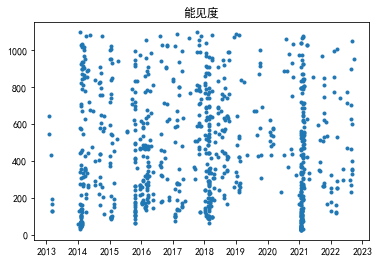

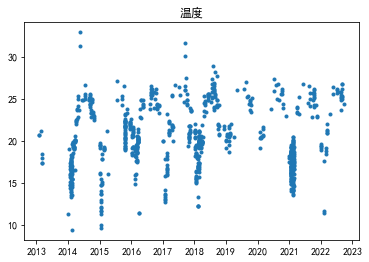

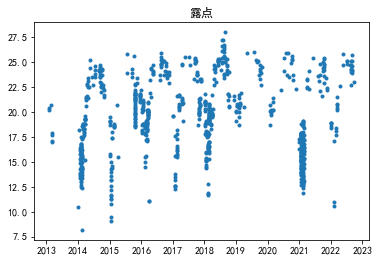

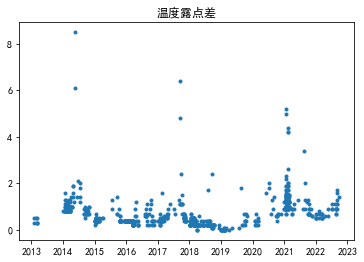

In [23]:
plt.plot(df_fog.index, df_fog[code_info['vis01']], '.')
plt.title('能见度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']], '.')
plt.title('温度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['td']], '.')
plt.title('露点')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']]-df_fog[code_info['td']], '.')
plt.title('温度露点差')
plt.show()

In [26]:
df_fog[code_info["month"]].value_counts()

2     237
1     217
10    101
3      84
8      46
9      46
4      39
7      20
11     18
5      15
12     15
6      13
Name: V04002, dtype: int64

In [ ]:
# 统计温度, T-Td, 相对湿度, Td, 月份, 小时

In [7]:
print(df_code['中文名'] == '气温')

0      False
1      False
2      False
3      False
4      False
       ...  
265    False
266    False
267    False
268    False
269    False
Name: 中文名, Length: 270, dtype: bool
